In [1]:
from ase.io import read
from pathlib import Path
from dscribe.descriptors import SOAP, ACSF
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# global_path = Path('/home/ebychkov/Teach/HPPL_project/')
global_path =Path('')
# structure_file = global_path / 'data' / 'heterostructure.data'
structure_file = global_path / 'data' / 'multiphase.dat'
structure = read(structure_file, format='lammps-data')
unique_symbols = set(structure.symbols)
print(unique_symbols)
len(structure)

{'Hf', 'N', 'Ti', 'B'}


28938

In [3]:
species_str = np.array(list(unique_symbols))
R_cut = 6
n_max = 8
l_max = 4

In [4]:
species_str

array(['B', 'Ti', 'N', 'Hf'], dtype='<U2')

In [16]:
acsf = ACSF(
    species=species_str,        # Список всех возможных элементов в твоем датасете
    r_cut=R_cut,                  # Радиус сферы окружения (в Ангстремах)
    g2_params=[[1, 2], [1, 4]], # Параметры радиальных функций [[eta, Rs], ...]
    g4_params=[[1, 2, 1]],      # Параметры угловых функций [[eta, zeta, lambda], ...]
    periodic=True,             # Важно: False для молекул, True для кристаллов
    sparse=False                # Возвращать обычный numpy массив (быстрее для GPU/Torch)
)

In [4]:
soap = SOAP(
    species=species_str,
    periodic=True,
    r_cut=R_cut,
    n_max=n_max,
    l_max=l_max,
    compression = {'mode':'mu2'})

In [18]:
# %%timeit
# local_environments = acsf.create(structure, n_jobs=1)

In [5]:
local_enviroments = soap.create(structure, n_jobs = 1)

In [6]:
local_enviroments.shape

(28938, 180)

In [23]:
n_tests = 1
time_arr = []
for n_jobs in range(1, 6):
    total_time = timeit.timeit(lambda: soap.create(structure, n_jobs=n_jobs), number=n_tests)
    time_arr.append(total_time/ n_tests)

In [24]:
time_arr =np.array( time_arr)

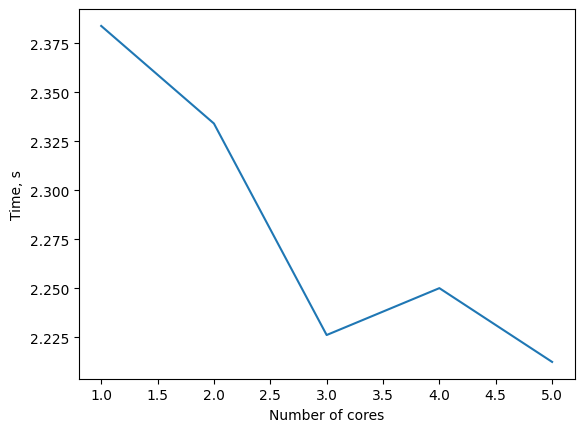

In [25]:
plt.plot(np.arange(1, 6), time_arr)
plt.xlabel("Number of cores")
plt.ylabel("Time, s")
plt.savefig(global_path/ 'tests' / 'check_time_small_str.png')
plt.show()

In [ ]:
total_time = timeit.timeit(lambda: soap.create(structure, n_jobs=4), number=2)
total_time

2.8520547673106194

In [22]:
%%writefile  UMAP_testin_speed.py
from ase.io import read
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from dscribe.descriptors import SOAP, ACSF
import timeit
import logging
import matplotlib.pyplot as plt
import numpy as np
import umap
global_path = Path('/home/ebychkov/Teach/HPPL_project/')
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(global_path/ 'tests'/ 'app_UMAP.log'),
        logging.StreamHandler()  # также выводит в консоль
    ]
)
logger = logging.getLogger(__name__)
logger.info('Отладка началась')

structure_file = global_path / 'data' / 'HfB2_5gr_p1.dat'
structure = read(structure_file, format='lammps-data')
unique_symbols = set(structure.symbols)
species_str = np.array(list(unique_symbols))
logger.info("Структура считана успешно")
species_str = ["Ti", "Zr", "Ta", "Hf", "Nb", "B"]
R_cut = 8
n_max = 8
l_max = 4
soap = SOAP(
    species=species_str,
    periodic=False,
    r_cut=R_cut,
    n_max=n_max,
    l_max=l_max,
    compression = {'mode':'mu2'})
local_enviroments = soap.create(structure, n_jobs = 1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(local_enviroments)
logger.info('Дискрипторы посчитаны')

def UMAP_working(df_scaled, n_jobs = -1):
    reducer = umap.UMAP(
    n_neighbors=300,
    n_components=10,  # Сжимаем до 10 измерений для кластеризации
    min_dist=0.0,
    metric='cosine',
    n_jobs = n_jobs# Для высокой размерности cosine часто лучше euclidean
    )
    embedding = reducer.fit_transform(df_scaled)

logger.info('Запускаем расчет для маленькой структуры')
n_tests = 10
cores_arr = np.array([1,2,4, 8, 12, 24])
time_arr = np.ones_like(cores_arr)

for i, n_jobs in enumerate(cores_arr):
    total_time = timeit.timeit(lambda: UMAP_working(df_scaled, n_jobs=n_jobs), number=n_tests)
    logger.debug(f'n_cores = {n_jobs}, total time = {total_time / n_tests}, Speedup = {total_time / n_tests/ time_arr[0]}')
    time_arr[i] = total_time/ n_tests
logger.info('Закончили расчет для маленькой структуры')
plt.plot(np.arange(1, 6), time_arr)
plt.xlabel("Number of cores")
plt.ylabel("Time, s")
plt.savefig(global_path/ 'tests' / 'check_time_UMAP.png')
plt.show()
logger.info('Сохранили файл расчет для маленькой структуры')

Writing UMAP_testin_speed.py


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(local_enviroments)
pca = PCA(n_components=3)
df_after_PCA = pca.fit_transform(X=df_scaled)
df_after_PCA.shape

(28938, 3)

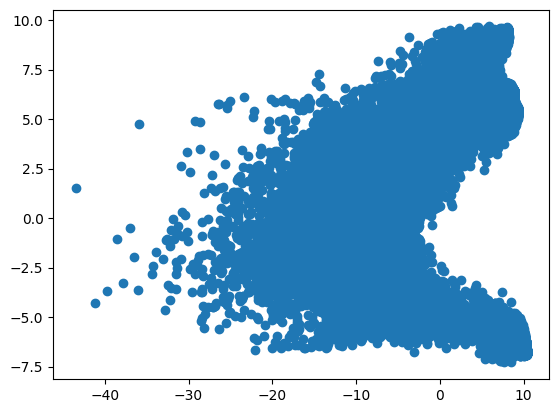

In [9]:
plt.scatter(df_after_PCA[:,0], df_after_PCA[:, 1])

In [20]:
import plotly.graph_objects as go
# import numpy as np

# # Тестовый график
# fig = go.Figure(data=[go.Scatter3d(
#     x=df_after_PCA[:, 0],
#     y=df_after_PCA[:, 1],
#     z=df_after_PCA[:, 2],
#     mode='markers',
#     marker=dict(size=3)
# )])
# fig.show()

In [8]:
soap_test = SOAP(
    species=species_str,
    periodic=True,
    r_cut=5,
    n_max=n_max,
    l_max=l_max,
    compression = {'mode':'mu2'})
local_enviroments = soap_test.create(structure, n_jobs = 1)
local_enviroments.shape

(28938, 180)

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(local_enviroments)


In [10]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

def check_optimal_epsilon(k, df_after_PCA):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(df_after_PCA)
    distances, indices = neighbors_fit.kneighbors(df_after_PCA)
    distances = np.sort(distances[:, k-1], axis=0)

    # Рисуем график
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f"График k-расстояний (k={k})")
    plt.xlabel("Точки, отсортированные по расстоянию")
    plt.ylabel(f"Расстояние до {k}-го соседа (Eps candidate)")
    plt.grid(True)
    plt.show()

In [11]:
import plotly.express as px
def visualise_str_labels(structure, labels):
    positions = structure.get_positions()
    df = pd.DataFrame({
    'x': positions[:, 0],
    'y': positions[:, 1],
    'z': positions[:, 2],
    'category': labels,
    })

    # Способ 1: Plotly Express (проще)
    fig = px.scatter_3d(df, 
                        x='x', y='y', z='z',
                        color='category',  # цвет по категории
                        symbol='category',  # разные маркеры для категорий     # размер по числовой переменной
                        opacity=0.8,
                        title='3D точки с категориальными признаками',
                        color_discrete_sequence=px.colors.qualitative.Set1)
    fig.update_layout(coloraxis_showscale=False)
    fig.show()

In [12]:
def clusterisation(k, eps, df_after_PCA):
    CHOSEN_EPS = eps
    CHOSEN_MIN_SAMPLES = k # То же k, что использовали выше

    print(f"Запуск DBSCAN с eps={CHOSEN_EPS}...")
    db = DBSCAN(eps=CHOSEN_EPS, min_samples=CHOSEN_MIN_SAMPLES, n_jobs=-1)
    labels = db.fit_predict(df_after_PCA)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(f"Найдено кластеров: {n_clusters_}")
    print(f"Точек шума (выбросов): {n_noise_}")
    return(labels)
    

In [13]:
import umap

In [14]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(local_enviroments)
reducer = umap.UMAP(
    n_neighbors=300,
    n_components=10,  # Сжимаем до 10 измерений для кластеризации
    min_dist=0.0,
    metric='cosine',
    n_jobs = 4# Для высокой размерности cosine часто лучше euclidean
)
embedding = reducer.fit_transform(df_scaled)
embedding

KeyboardInterrupt: 

In [18]:
embedding.shape

(28938, 10)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(local_enviroments)
pca = PCA(n_components=6)
df_after_PCA = pca.fit_transform(X=df_scaled)
df_after_PCA.shape

(28938, 6)

In [14]:
import hdbscan
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,       
    min_samples=50,            
    metric='euclidean',        # Для кристаллов только Евклид!
    cluster_selection_method='eom', # 'eom' лучше подходит для больших плотных структур
    gen_min_span_tree=True     # Нужно для визуализации (опционально)
)
print("Запуск кластеризации...")
labels = clusterer.fit_predict(df_after_PCA)

# 4. АНАЛИЗ РЕЗУЛЬТАТОВ
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
percent_noise = (n_noise / len(labels)) * 100

print(f"Найдено фаз (кластеров): {n_clusters}")
print(f"Атомов в шуме (дефекты/границы): {n_noise} ({percent_noise:.2f}%)")

Запуск кластеризации...
Найдено фаз (кластеров): 5
Атомов в шуме (дефекты/границы): 11164 (38.58%)


In [9]:
from ase.visualize import view
import nglview as nv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [10]:
def visualise_new(atoms, labels):
    unique_clusters = np.unique(labels)

    cmap = plt.get_cmap('tab20', len(unique_clusters))
    color_list = [mcolors.to_hex(cmap(i)) for i in range(len(unique_clusters))]

    color_selection_map = []
    for cluster_id, color in zip(unique_clusters, color_list):
        indices = np.where(labels == cluster_id)[0]
        selection = "@" + ",".join(map(str, indices))
        color_selection_map.append([color, selection])

    view = nv.show_ase(atoms)
    view.clear_representations()

    custom_scheme = nv.color._ColorScheme(color_selection_map, label="cluster_scheme")
    view.add_representation("spacefill", color=custom_scheme, opacity=1)
    return view

In [15]:
view = visualise_new(structure, labels)
view

NGLWidget()

In [18]:
visualise_str_labels(structure, labels)

In [21]:
# Тестовый график
fig = go.Figure(data=[go.Scatter3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    mode='markers',
    marker=dict(size=3)
)])
fig.show()

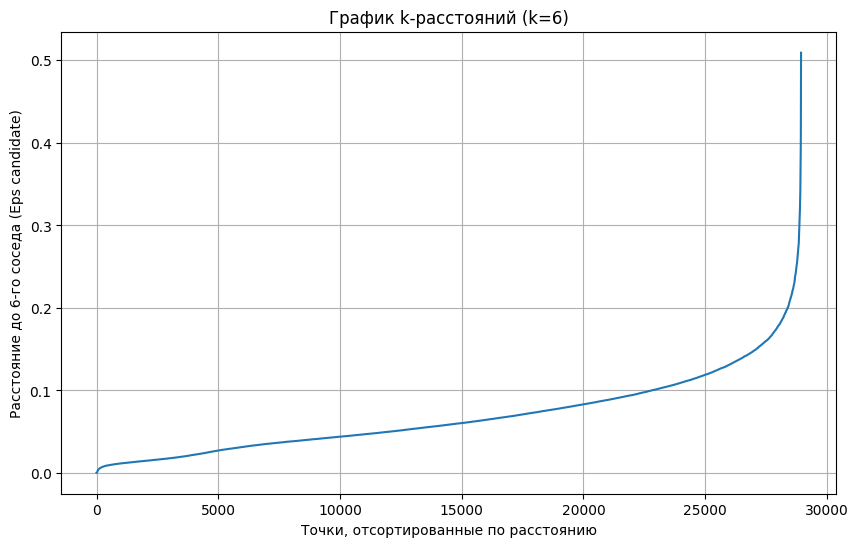

In [81]:
check_optimal_epsilon(6, embedding)

In [82]:
visualise_str_labels(structure, clusterisation(6,0.2, embedding))

Запуск DBSCAN с eps=0.2...
Найдено кластеров: 13
Точек шума (выбросов): 206
